# Balance musicians' age distribution
We have collected the distributions of age across all musicians shared on Spotify and YouTube, based on Facebook "likes". 

- How well can we balance these distributions across the two main groups of interest, i.e. US American musicians and Latin American musicians?
- After balancing, do we find any difference in P(share Latin American music | integrated loanword) vs. P(share Latin American music | light verb loanword)?

First get video data.

In [47]:
from data_helpers import try_literal_eval
# import pandas as pd
# # load music sharing data
video_share_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_youtube_video_data_full.tsv', sep='\t')
# # load video metadata
video_category_data = pd.read_csv('../../data/culture_metadata/youtube_video_music_genre_data.tsv', sep='\t', 
                                  converters={'us_american_artist_tags' : try_literal_eval, 'latin_american_artist_tags' : try_literal_eval})
# combine all artist tags
video_category_data = video_category_data.assign(**{
    'combined_artist_tags' : video_category_data.loc[:, ['us_american_artist_tags', 'latin_american_artist_tags']].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
})

Next get age distribution data.

In [54]:
from ast import literal_eval
audience_data = pd.read_csv('../../data/culture_metadata/audience_size_FB_estimates.tsv', sep='\t', converters={'age_range' : literal_eval})
# fix interest name
interest_name_var = 'interest_name'
audience_data = audience_data.assign(**{
    interest_name_var : audience_data.loc[:, interest_name_var].apply(lambda x: x.lower())
})
# compute percents
audience_pct_data = []
audience_count_var = 'estimate_mau'
audience_pct_var = f'{audience_count_var}_pct'
for interest_i, data_i in audience_data.groupby(interest_name_var):
    pct_i = data_i.loc[:, audience_count_var] / data_i.loc[:, audience_count_var].sum()
    data_i = data_i.assign(**{
        audience_pct_var : pct_i
    })
    audience_pct_data.append(data_i)
audience_data = pd.concat(audience_pct_data, axis=0)
audience_age_categories = audience_data.loc[:, 'age_range'].unique()
display(audience_data.head())

,estimate_mau,age_range,interest_name,estimate_mau_pct
0,61000,"(15, 25)",11:11,0.053935
1,240000,"(25, 35)",11:11,0.212202
2,310000,"(35, 45)",11:11,0.274094
3,520000,"(45, 65)",11:11,0.459770
4,1500000,"(15, 25)",2 chainz,0.406504


### Collect age distributions
Let's collect the age distributions among the links with US American artists and the links with Latin American artists. 
We will treat each link as a "unit" in the population.

We will assign the "age" of a link as the average age distribution over all artists represented in the link.

In [24]:
# data should be organized by link
# link | valid tags | 15_25_pct | 25_35_pct | etc.
audience_pct_lookup = audience_data.groupby(interest_name_var).apply(lambda x: x.loc[:, audience_pct_var].values).to_dict()
print(audience_pct_lookup['2 chainz'])

[0.40650407 0.40650407 0.13550136 0.05149051]


In [42]:
import numpy as np
def assign_audience_pct(interests, audience_pct_lookup, audience_pct_count=4):
    interest_pcts = list(map(audience_pct_lookup.get, interests))
    interest_pcts = list(filter(lambda x: x is not None, interest_pcts))
    mean_audience_pct = np.zeros(audience_pct_count)
    # compute mean over all interests
    if(len(interest_pcts) > 0):
        interest_pcts = list(map(lambda x: x.reshape(-1,1), interest_pcts))
        audience_pcts = np.concatenate(interest_pcts, axis=1).T
        mean_audience_pct = np.mean(audience_pcts, axis=0)
    return mean_audience_pct

In [44]:
test_interests = ['2 chainz', 'shakira']
test_audience_pct = assign_audience_pct(test_interests, audience_pct_lookup, audience_pct_count=len(audience_age_categories))
print(test_audience_pct)

[0.40650407 0.40650407 0.13550136 0.05149051]


In [57]:
combined_tag_var = 'combined_artist_tags'
audience_video_category_data = video_category_data[video_category_data.loc[:, combined_tag_var].apply(lambda x: len(x) > 0 and len(set(x) & set(audience_pct_lookup.keys())) > 0)]
audience_video_category_data = audience_video_category_data.loc[:, ['youtube_id', 'video_genre', 'combined_artist_tags']]
print(audience_video_category_data.shape[0])
print(audience_video_category_data.loc[:, 'video_genre'].value_counts())
audience_pct_means = audience_video_category_data.loc[:, combined_tag_var].apply(lambda x: assign_audience_pct(x, audience_pct_lookup, len(audience_age_categories)))
# reorganize
for i, age_category_i in enumerate(audience_age_categories):
    age_category_i_str = 'AGE={%s_%s}_pct'%(age_category_i[0], age_category_i[1])
    audience_video_category_data = audience_video_category_data.assign(**{
        age_category_i_str : audience_pct_means.apply(lambda x: x[i])
    })
display(audience_video_category_data.head())

2059
us_american_music       1534
latin_american_music     525
Name: video_genre, dtype: int64


,youtube_id,video_genre,combined_artist_tags,AGE={15_25}_pct,AGE={25_35}_pct,AGE={35_45}_pct,AGE={45_65}_pct
6,WT-VE9OyAJk,latin_american_music,{mon laferte},0.341463,0.353659,0.170732,0.134146
24,cJtCyqB2uFg,latin_american_music,"{so pra contrariar, alexandre pires}",0.144044,0.332410,0.277008,0.246537
26,EPxhuQQVazM,latin_american_music,{carlos vives},0.236842,0.321637,0.242690,0.198830
27,Ic7JegzQk_o,latin_american_music,"{alejandro fernandez, eiza gonzalez, cristian ...",0.330235,0.299199,0.196224,0.174342
30,oBwIdYX85BI,latin_american_music,{sebastian yatra},0.564103,0.307692,0.082051,0.046154


### Check audience balance

What is the distribution of percents between videos of different genres?

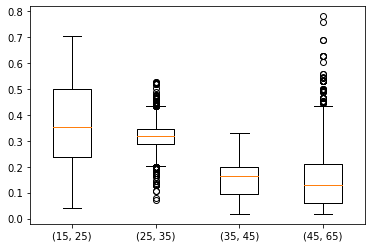

In [63]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# plot full distribution
age_category_vars = list(map(lambda x: 'AGE={%s_%s}_pct'%(x[0], x[1]), audience_age_categories))
video_age_category_pcts = audience_video_category_data.loc[:, age_category_vars].transpose()
X = np.arange(len(age_category_vars))+1
plt.boxplot(video_age_category_pcts)
plt.xticks(X, audience_age_categories)
plt.show()

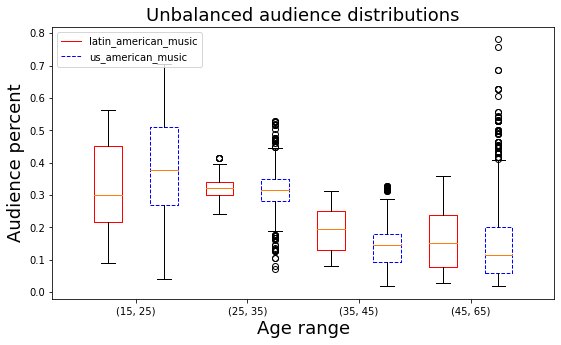

In [215]:
# plot distribution per genre
latin_american_musician_audience_video_category_data = audience_video_category_data[audience_video_category_data.loc[:, 'video_genre']=='latin_american_music']
us_american_musician_audience_video_category_data = audience_video_category_data[audience_video_category_data.loc[:, 'video_genre']=='us_american_music']
latin_american_video_age_category_pcts = latin_american_musician_audience_video_category_data.loc[:, age_category_vars].transpose()
us_american_video_age_category_pcts = us_american_musician_audience_video_category_data.loc[:, age_category_vars].transpose()
# plot separately
box_width = 0.25
box_offset = 0.25
plt.figure(figsize=(9,5))
box1 = plt.boxplot(latin_american_video_age_category_pcts, positions=X-box_offset, widths=box_width, boxprops={'color':'r', 'linestyle':'-'})
box2 = plt.boxplot(us_american_video_age_category_pcts, positions=X+box_offset, widths=box_width, boxprops={'color':'b', 'linestyle':'--'})
box_plots = [box1, box2]
box_plots = list(map(lambda x: x['boxes'][0], box_plots))
genre_vals = ['latin_american_music', 'us_american_music']
plt.xticks(X, audience_age_categories)
plt.xlabel('Age range', fontsize=18)
plt.ylabel('Audience percent', fontsize=18)
plt.legend(box_plots, genre_vals, loc='upper left')
plt.title('Unbalanced audience distributions', fontsize=18)
plt.show()

It appears that US music skews a bit younger.

## Balance distributions
Let's try to balance the distributions by matching each US American musician video with a corresponding Latin American musician video.

First step: nearest neighbors.

In [204]:
# stolen from https://stats.stackexchange.com/questions/206832/matched-pairs-in-python-propensity-score-matching
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial.distance import cdist

def get_matching_pairs(treated_df, non_treated_df, scaler=True):
    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)
    
    # how to prevent duplicate matching?
    # greedy matching: randomly select treatment var
    # cosine sim => not good
#     treat_non_treat_dist = treated_df.dot(non_treated_df.T)/(linalg.norm(treated_df)*linalg.norm(non_treated_df))
    # mahalanobis distance => much better
    treat_non_treat_dist = cdist(treated_df.values, non_treated_df.values, 'mahalanobis')
#     treat_non_treat_dist = treat_non_treat_dist.values
    # iterate through treated vals randomly
    np.random.seed(456)
    N_treated = len(treated_df.index)
    treated_df_idx = np.random.choice(list(range(N_treated)), N_treated, replace=False)
    matched_idx = []
    for i in treated_df_idx:
        nearest_neighbors_i = np.argsort(treat_non_treat_dist[i, :])
        nearest_neighbor_idx_i = nearest_neighbors_i[0]
        # get next-nearest neighbor until we get a valid index
        nearest_neighbor_ctr = 1
        while(nearest_neighbor_idx_i in matched_idx):
            nearest_neighbor_idx_i = nearest_neighbors_i[nearest_neighbor_ctr]
            nearest_neighbor_ctr += 1
        matched_idx.append(nearest_neighbor_idx_i)
    matched = non_treated_df.iloc[matched_idx, :]
    # nearest neighbors with replacement...DUMB!!
#     nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_treated_x)
#     distances, indices = nbrs.kneighbors(treated_x)
#     indices = indices.reshape(indices.shape[0])
#     matched = non_treated_df.iloc[indices, :]
    return matched

In [205]:
treated_df = pd.DataFrame(latin_american_video_age_category_pcts.T)
control_df = pd.DataFrame(us_american_video_age_category_pcts.T)
match_df = get_matching_pairs(treated_df, control_df, scaler=True)

In [206]:
# map these back to the original data
matched_audience_video_category_data = [
    latin_american_musician_audience_video_category_data.loc[treated_df.index, :],
    us_american_musician_audience_video_category_data.loc[match_df.index, :]
]
matched_audience_video_category_data = pd.concat(matched_audience_video_category_data, axis=0)

How do the matches look?

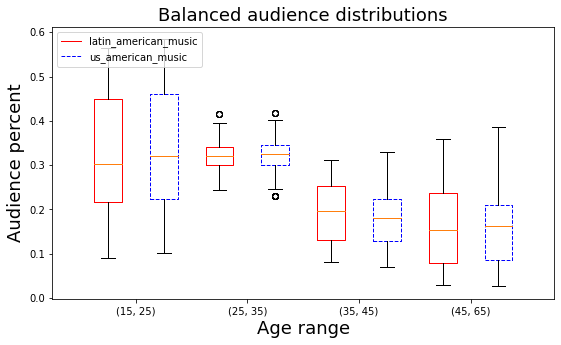

In [216]:
# plot separately
matched_latin_american_video_age_category_pcts = matched_audience_video_category_data[matched_audience_video_category_data.loc[:, 'video_genre']=='latin_american_music'].loc[:, age_category_vars].transpose()
matched_us_american_video_age_category_pcts = matched_audience_video_category_data[matched_audience_video_category_data.loc[:, 'video_genre']=='us_american_music'].loc[:, age_category_vars].transpose()
box_width = 0.25
box_offset = 0.25
plt.figure(figsize=(9,5))
box1 = plt.boxplot(matched_latin_american_video_age_category_pcts, positions=X-box_offset, widths=box_width, boxprops={'color':'r', 'linestyle':'-'})
box2 = plt.boxplot(match_df.values, positions=X+box_offset, widths=box_width, boxprops={'color':'b', 'linestyle':'--'})
box_plots = [box1, box2]
box_plots = list(map(lambda x: x['boxes'][0], box_plots))
genre_vals = ['latin_american_music', 'us_american_music']
plt.xticks(X, audience_age_categories)
plt.xlabel('Age range', fontsize=18)
plt.ylabel('Audience percent', fontsize=18)
plt.title('Balanced audience distributions', fontsize=18)
plt.legend(box_plots, genre_vals, loc='upper left')
plt.show()

Better! Using Mahalanobis distance reduced the potential for overfitting to the extrema (e.g. higher penalty for old ages).

### Compare media sharing among integrated and light verb authors
After balancing, is there a difference in the rate of sharing among authors who used an integrated vs. light verb authors?

In [190]:
# load video sharing data
author_video_share_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_youtube_video_data_full.tsv', sep='\t')
display(author_video_share_data.head())

,id,youtube_id,youtube_id_category,screen_name
0,701059621830660096,9FYlJp3uWt4,NaN,01800bateria
1,698522981564358656,9VDmIwZkDBQ,NaN,01800bateria
2,695986160926134272,7GFHgxjELqY,NaN,01800bateria
3,1135661216444178441,u5CVsCnxyXg,NaN,07jun11
4,1116579616578101249,2B6qerZlczw,us_american_artist,07jun11


If we restrict to matching videos, how much data do we have left?

In [208]:
matched_video_ids = matched_audience_video_category_data.loc[:, 'youtube_id'].unique()
valid_author_video_share_data = author_video_share_data[author_video_share_data.loc[:, 'youtube_id'].isin(matched_video_ids)]
print('%d/%d valid data'%(valid_author_video_share_data.shape[0], author_video_share_data.shape[0]))
print('%d/%d authors'%(valid_author_video_share_data.loc[:, 'screen_name'].nunique(), 
                       author_video_share_data.loc[:, 'screen_name'].nunique()))

1648/104455 valid data
689/6120 authors


Wow that's small. I hope it gets us somewhere!!

In [217]:
# separate authors by type
loanword_author_post_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t')
print(loanword_author_post_data.shape[0])
display(loanword_author_post_data.head())

87610


,loanword,loanword_verb,loanword_type,screen_name,user_id,text,date,id,user_description,user_location,...,us_american_artist_video_count,latin_american_artist_video_pct,total_music_count,latin_american_music_genre_pct,latin_american_music_genre_count,us_american_music_genre_count,latin_american_media_count,us_american_media_count,latin_american_media_pct,integrated_verb_pct
0,audit,auditamos,integrated_loanword,garrachavista,779318307585396736,@Sheiladarsy @anticuarta4 Y dime tu cuales 7.6...,NaN,892506833197424640,100% a la izquierda,Venezuela,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,ban,baneamos,integrated_loanword,emmanuelkiller5,4273648032,@adameamiro Eres tan hipocrita que antes nos h...,NaN,882375684823203841,"Felicidad?Que es eso, lo que todos siempre me ...","Chihuahua, Chihuahua",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ban,baneamos,integrated_loanword,danitolocirio13,482233447,@LVPibai Ibai te hace una normal de reclu? Así...,NaN,893999585953185793,#21. Me gusta Love Live. Reborn. Baraggan y Es...,"Valladolid, España",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,flip,flipas,integrated_loanword,danitolocirio13,482233447,Me echaba unas rankeds ahora que flipas,NaN,949837604362612736,#22. Vago...,"Valladolid, España",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,ban,banear,integrated_loanword,vcf973,883037197754093569,@MiiKeLMsT MIKEEL! CASI ME BANEAN POR COMPRAR ...,NaN,899277329012334593,.,Tenerife,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
# # get verb type counts
# author_var = 'screen_name'
# verb_type_var = 'loanword_type'
# author_light_verb_pct = loanword_author_post_data.groupby(author_var).apply(lambda x: x[x.loc[:, 'loanword_type']=='light_verb_loanword'].shape[0] / x.shape[0])
# print(author_light_verb_pct.head())
# identify "light verb" authors as those with at least 50% use
verb_use_cutoff = 0.5
light_verb_loanword_authors = author_light_verb_pct[author_light_verb_pct > verb_use_cutoff].index.tolist()
integrated_verb_loanword_authors = author_light_verb_pct[author_light_verb_pct < verb_use_cutoff].index.tolist()
print('%d light verb authors'%(len(light_verb_loanword_authors)))
print('%d integrated verb authors'%(len(integrated_verb_loanword_authors)))

24892 light verb authors
55312 integrated verb authors


Could be worse!!

In [209]:
from scipy.stats import chi2_contingency
# get contingency matrix for chi-2 test
# count = media links shared (Latin American vs. US American)
light_verb_author_valid_author_video_share_data = valid_author_video_share_data[valid_author_video_share_data.loc[:, author_var].isin(light_verb_loanword_authors)]
integrated_verb_author_valid_author_video_share_data = valid_author_video_share_data[valid_author_video_share_data.loc[:, author_var].isin(integrated_verb_loanword_authors)]
contingency_matrix = [
    [light_verb_author_valid_author_video_share_data[light_verb_author_valid_author_video_share_data.loc[:, 'youtube_id_category']=='us_american_artist'].shape[0], 
     integrated_verb_author_valid_author_video_share_data[integrated_verb_author_valid_author_video_share_data.loc[:, 'youtube_id_category']=='us_american_artist'].shape[0]],
    [light_verb_author_valid_author_video_share_data[light_verb_author_valid_author_video_share_data.loc[:, 'youtube_id_category']=='latin_american_artist'].shape[0], 
     integrated_verb_author_valid_author_video_share_data[integrated_verb_author_valid_author_video_share_data.loc[:, 'youtube_id_category']=='latin_american_artist'].shape[0]]
]
contingency_matrix = pd.DataFrame(contingency_matrix, 
                                  index=['us_american_artist_share_count', 'latin_american_artist_share_count'], 
                                  columns=['light_verb_author', 'integrated_verb_author']).transpose()
contingency_matrix_norm = contingency_matrix.div(contingency_matrix.sum(axis=1), axis=0)
display(contingency_matrix)
display(contingency_matrix_norm)
test_stat, p_val, dof, expected = chi2_contingency(contingency_matrix.values)
print('difference is significant with test stat=%.3f (p=%.3E)'%(test_stat, p_val))

,us_american_artist_share_count,latin_american_artist_share_count
light_verb_author,211,240
integrated_verb_author,472,709


,us_american_artist_share_count,latin_american_artist_share_count
light_verb_author,0.467849,0.532151
integrated_verb_author,0.399661,0.600339


difference is significant with test stat=5.958 (p=1.465E-02)


OK! It appears that light verb authors tend to share slightly more US American music ($p<0.05$ lol).

For control: do we see the same effect for native verb authors?

In [218]:
native_verb_author_post_data = pd.read_csv('../../data/mined_tweets/native_verb_use_author_social_data.tsv', sep='\t')
print(native_verb_author_post_data.shape[0])

330988


In [222]:
author_native_light_verb_pct = native_verb_author_post_data.groupby(author_var).apply(lambda x: x[x.loc[:, 'native_word_category']=='native_light_verb'].shape[0] / x.shape[0])
# identify "light verb" authors as those with at least 50% use
verb_use_cutoff = 0.5
native_light_verb_authors = author_native_light_verb_pct[author_native_light_verb_pct > verb_use_cutoff].index.tolist()
native_integrated_verb_authors = author_native_light_verb_pct[author_native_light_verb_pct < verb_use_cutoff].index.tolist()
print('%d light verb authors'%(len(native_light_verb_authors)))
print('%d integrated verb authors'%(len(native_integrated_verb_authors)))

562 light verb authors
32416 integrated verb authors


In [223]:
from scipy.stats import chi2_contingency
# get contingency matrix for chi-2 test
# count = media links shared (Latin American vs. US American)
light_verb_author_valid_author_video_share_data = valid_author_video_share_data[valid_author_video_share_data.loc[:, author_var].isin(native_light_verb_authors)]
integrated_verb_author_valid_author_video_share_data = valid_author_video_share_data[valid_author_video_share_data.loc[:, author_var].isin(native_integrated_verb_authors)]
contingency_matrix = [
    [light_verb_author_valid_author_video_share_data[light_verb_author_valid_author_video_share_data.loc[:, 'youtube_id_category']=='us_american_artist'].shape[0], 
     integrated_verb_author_valid_author_video_share_data[integrated_verb_author_valid_author_video_share_data.loc[:, 'youtube_id_category']=='us_american_artist'].shape[0]],
    [light_verb_author_valid_author_video_share_data[light_verb_author_valid_author_video_share_data.loc[:, 'youtube_id_category']=='latin_american_artist'].shape[0], 
     integrated_verb_author_valid_author_video_share_data[integrated_verb_author_valid_author_video_share_data.loc[:, 'youtube_id_category']=='latin_american_artist'].shape[0]]
]
contingency_matrix = pd.DataFrame(contingency_matrix, 
                                  index=['us_american_artist_share_count', 'latin_american_artist_share_count'], 
                                  columns=['light_verb_author', 'integrated_verb_author']).transpose()
contingency_matrix_norm = contingency_matrix.div(contingency_matrix.sum(axis=1), axis=0)
display(contingency_matrix)
display(contingency_matrix_norm)
test_stat, p_val, dof, expected = chi2_contingency(contingency_matrix.values)
print('difference is significant with test stat=%.3f (p=%.3E)'%(test_stat, p_val))

,us_american_artist_share_count,latin_american_artist_share_count
light_verb_author,0,1
integrated_verb_author,679,941


,us_american_artist_share_count,latin_american_artist_share_count
light_verb_author,0.000000,1.000000
integrated_verb_author,0.419136,0.580864


difference is significant with test stat=0.027 (p=8.694E-01)


OK! The rate is similar for integrated verb authors but we don't have enough data for the light verb authors to compare.

### Balance age distribution: all media
Let's do the same thing but with all media sharing, i.e. YouTube and Spotify.

In [1]:
## reload audience data
import pandas as pd
from ast import literal_eval
audience_data = pd.read_csv('../../data/culture_metadata/audience_size_FB_estimates.tsv', sep='\t', converters={'age_range' : literal_eval})
# fix interest name
interest_name_var = 'interest_name'
audience_data = audience_data.assign(**{
    interest_name_var : audience_data.loc[:, interest_name_var].apply(lambda x: x.lower())
})
# compute percents
audience_pct_data = []
audience_count_var = 'estimate_mau'
audience_pct_var = f'{audience_count_var}_pct'
for interest_i, data_i in audience_data.groupby(interest_name_var):
    pct_i = data_i.loc[:, audience_count_var] / data_i.loc[:, audience_count_var].sum()
    data_i = data_i.assign(**{
        audience_pct_var : pct_i
    })
    audience_pct_data.append(data_i)
audience_data = pd.concat(audience_pct_data, axis=0)
audience_age_categories = audience_data.loc[:, 'age_range'].unique()
display(audience_data.head())
# data should be organized by link
# link | valid tags | 15_25_pct | 25_35_pct | etc.
audience_pct_lookup = audience_data.groupby(interest_name_var).apply(lambda x: x.loc[:, audience_pct_var].values).to_dict()

,estimate_mau,age_range,interest_name,estimate_mau_pct
0,61000,"(15, 25)",11:11,0.053935
1,240000,"(25, 35)",11:11,0.212202
2,310000,"(35, 45)",11:11,0.274094
3,520000,"(45, 65)",11:11,0.459770
4,1500000,"(15, 25)",2 chainz,0.406504


### Plot artist ages by genre

First, let's plot the youngest and oldest artists in each genre.

In [3]:
# get artist genres for videos
from data_helpers import try_literal_eval
import numpy as np
import pandas as pd
from functools import reduce
video_artist_genre_data = pd.read_csv('../../data/culture_metadata/youtube_video_music_genre_data.tsv', sep='\t',
                                      usecols=['latin_american_artist_tags', 'us_american_artist_tags'], 
                                      converters={'latin_american_artist_tags' : try_literal_eval, 'us_american_artist_tags' : try_literal_eval})
# flatten to artist | genre
video_artist_genre_data_flat = []
video_artist_genre_data_flat += list(map(lambda x: [x, 'latin_american'], reduce(lambda x,y: set(x)|set(y), video_artist_genre_data.loc[:, 'latin_american_artist_tags'].values)))
video_artist_genre_data_flat += list(map(lambda x: [x, 'us_american'], reduce(lambda x,y: set(x)|set(y), video_artist_genre_data.loc[:, 'us_american_artist_tags'].values)))
video_artist_genre_data_flat = pd.DataFrame(video_artist_genre_data_flat, columns=['artist_name', 'artist_genre'])
# display(video_artist_genre_data_flat.head())
# get artist genres for music
music_artist_data = pd.read_csv('../../data/culture_metadata/spotify_musician_data.tsv', sep='\t', usecols=['artist_id', 'name'])
music_genre_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_author_spotify_link_data.tsv', sep='\t', usecols=['artist_id', 'latin_american_genre', 'us_american_genre'])
music_artist_data = pd.merge(music_artist_data, music_genre_data, on='artist_id')
music_artist_genre_data_flat = []
music_artist_genre_data_flat += music_artist_data[music_artist_data.loc[:, 'latin_american_genre']].loc[:, 'name'].apply(lambda x: [x, 'latin_american_genre']).values.tolist()
music_artist_genre_data_flat += music_artist_data[music_artist_data.loc[:, 'us_american_genre']].loc[:, 'name'].apply(lambda x: [x, 'us_american_genre']).values.tolist()
music_artist_genre_data_flat = pd.DataFrame(music_artist_genre_data_flat, columns=['artist_name', 'artist_genre'])
# combined data
video_artist_genre_data_flat = video_artist_genre_data_flat.assign(**{
    'media_type': 'video'
})
music_artist_genre_data_flat = music_artist_genre_data_flat.assign(**{
    'media_type' : 'music'
})
media_artist_genre_data = pd.concat([video_artist_genre_data_flat, music_artist_genre_data_flat], axis=0)
media_artist_genre_data.drop_duplicates('artist_name', inplace=True)
media_artist_genre_data.rename(columns={'artist_name' : 'interest_name'}, inplace=True)
# join with audience data
media_artist_audience_data = pd.merge(media_artist_genre_data, audience_data, on='interest_name')
# compute artist "age" as average
def compute_mean_age(data):
    # compute mean age as expected value over all age ranges
    expected_age_vals = []
    for age_range_i, audience_pct_i in data.loc[:, ['age_range', 'estimate_mau_pct']].values:
        age_range_vals = np.arange(*age_range_i)
        age_range_size = age_range_i[1] - age_range_i[0]
        expected_age_i = (age_range_vals * audience_pct_i / age_range_size).sum()
        expected_age_vals.append(expected_age_i)
    expected_age = sum(expected_age_vals)
    return expected_age
artist_var = 'interest_name'
artist_mean_age = media_artist_audience_data.groupby(artist_var).apply(lambda x: compute_mean_age(x)).reset_index().rename(columns={0 : 'expected_age'})
media_artist_audience_data = pd.merge(media_artist_audience_data, artist_mean_age, on=artist_var)
# rename genre for plot
genre_full_name_lookup = {'latin_american' : 'Spanish/Latin American', 'us_american' : 'US/UK'}
media_artist_audience_data = media_artist_audience_data.assign(**{
    'artist_genre' : media_artist_audience_data.loc[:, 'artist_genre'].apply(lambda x: genre_full_name_lookup.get(x))
})
display(media_artist_audience_data.head())

,interest_name,artist_genre,media_type,estimate_mau,age_range,estimate_mau_pct,expected_age
0,natalia lafourcade,Spanish/Latin American,video,700000,"(15, 25)",0.327103,30.785047
1,natalia lafourcade,Spanish/Latin American,video,810000,"(25, 35)",0.378505,30.785047
2,natalia lafourcade,Spanish/Latin American,video,400000,"(35, 45)",0.186916,30.785047
3,natalia lafourcade,Spanish/Latin American,video,230000,"(45, 65)",0.107477,30.785047
4,grupo niche,Spanish/Latin American,video,150000,"(15, 25)",0.144231,37.336538


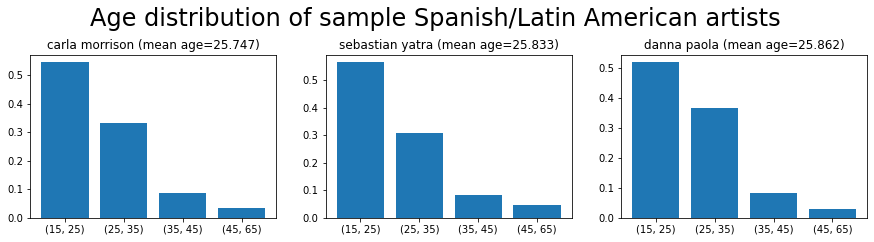

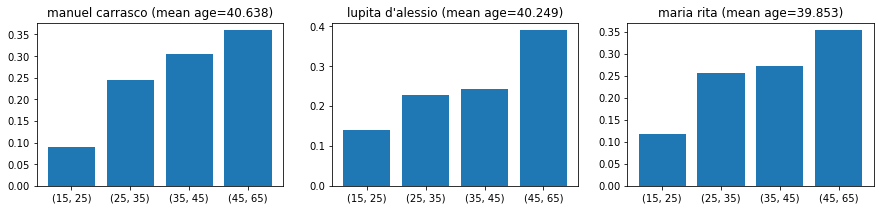

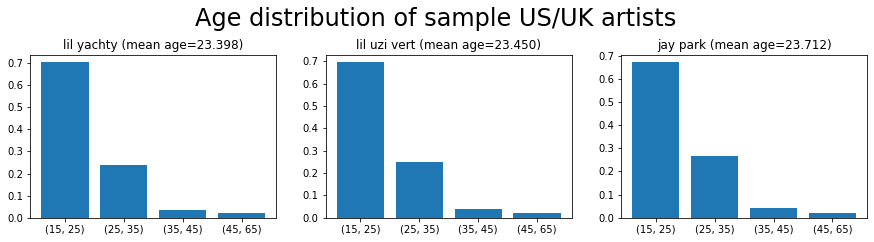

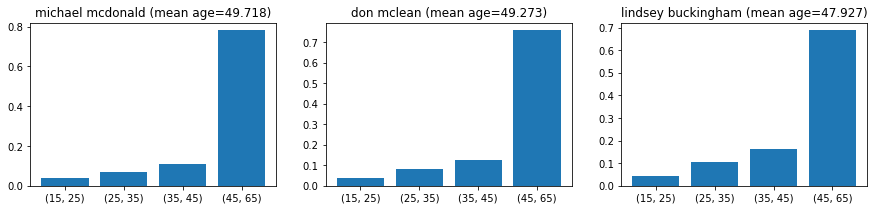

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from math import floor, ceil
def plot_artist_age_dist(data, top_k):
    artist_var = 'interest_name'
    age_var = 'expected_age'
    genre_var = 'artist_genre'
    age_pct_var = 'estimate_mau_pct'
    age_range_var = 'age_range'
    cols = 3
    rows = int(ceil(cols / top_k))
    f, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
    if(len(axs.shape) == 1):
        axs = axs.reshape(rows, cols)
    for j in range(top_k):
        artist_j = artist_mean_ages.iloc[j, :].loc[artist_var]
        age_j = artist_mean_ages.iloc[j, :].loc[age_var]
        data_j = data_i[data_i.loc[:, artist_var]==artist_j]
        ax = axs[int(floor(j / cols)), j % cols]
        X = np.arange(data_j.shape[0])
        age_pct_j = data_j.loc[:, age_pct_var].values
        ax.bar(X, age_pct_j)
        ax.set_xticks(X)
        ax.set_xticklabels(age_ranges)
        ax.set_title('%s (mean age=%.3f)'%(artist_j, age_j))
artist_var = 'interest_name'
age_var = 'expected_age'
genre_var = 'artist_genre'
age_pct_var = 'estimate_mau_pct'
age_range_var = 'age_range'
top_k = 3
X = data_i.loc[:, age_range_var].nunique()
age_ranges = data_i.loc[:, age_range_var].unique()
for genre_i, data_i in media_artist_audience_data.groupby(genre_var):
    artist_mean_ages = data_i.loc[:, [artist_var, age_var]].drop_duplicates(artist_var, inplace=False)
    # youngest
    artist_mean_ages.sort_values(age_var, ascending=True, inplace=True)
    plot_artist_age_dist(artist_mean_ages, top_k)
    plt.suptitle(f'Age distribution of sample {genre_i} artists', fontsize=24, y=1.10)
#     plt.suptitle(f'Age distribution of "youngest" {genre_i} artists', fontsize=24, y=1.10)
#     plt.show()
    # oldest
    artist_mean_ages.sort_values(age_var, ascending=False, inplace=True)
    plot_artist_age_dist(artist_mean_ages, top_k)
    plt.show()

### Collect sharing data for balancing

In [5]:
from data_helpers import try_literal_eval
import pandas as pd
# load spotify
spotify_musician_data = pd.read_csv('../../data/culture_metadata/spotify_musician_data.tsv', sep='\t', converters={'genres' : try_literal_eval})
spotify_musician_data = spotify_musician_data.assign(**{
    'name_clean' : spotify_musician_data.loc[:, 'name'].apply(lambda x: x.lower())
})
spotify_song_data = pd.read_csv('../../data/culture_metadata/spotify_track_data.tsv', sep='\t', converters={'artist_name' : try_literal_eval})
spotify_song_data = spotify_song_data.assign(**{
    'artist_name_clean' : spotify_song_data.loc[:, 'artist_name'].apply(lambda x: list(map(lambda y: y.lower(), x)))
})
spotify_song_data.rename(columns={'id' : 'track_id'}, inplace=True)
display(spotify_musician_data.head())
display(spotify_song_data.head())

,followers,genres,artist_id,name,popularity,name_clean
0,507962,"[alternative hip hop, detroit hip hop, escape ...",7aA592KWirLsnfb5ulGWvU,Danny Brown,63,danny brown
1,1479975,"[alternative metal, nu metal, post-grunge, rap...",5KDIH2gF0VpelTqyQS7udb,Staind,66,staind
2,11869,[vapor twitch],3iIFBDnPEFpR6PCF0Tuh6w,GEOTHEORY,35,geotheory
3,2474324,[nc hip hop],4r63FhuTkUYltbVAg5TQnk,DaBaby,91,dababy
4,51069,[ambient folk],3h0w83PsjASrm5999trG4n,Hamilton Leithauser + Rostam,33,hamilton leithauser + rostam


,track_id,explicit,name,album_id,album_name,album_release_date,album_available_markets,artist_id,artist_name,artist_name_clean
0,4NVzKq9K1Ryq9PSE9YyFuS,False,This Day We Fight!,0G5qC48D3MI8YBKTVwIiz1,ENDGAME,2009-09-09,78.0,['1Yox196W7bzVNZI7RBaPnf'],[Megadeth],[megadeth]
1,6OOk7nYKqKTCIQunirsVht,False,Somewhere Only We Know,62jIXzDsu18rooOl6dVu61,Hopes and Fears (Deluxe Edition),2009-01-01,0.0,['53A0W3U0s8diEn9RhXQhVz'],[Keane],[keane]
2,2bDENJyfbxj0neGiXUFvIX,False,Legendary,4UXg0K9s6iGFntzsrYDdWF,No Place Is Home,2018-05-25,79.0,['1xKrH6GSh9CJh8nYwbqW7B'],[Welshly Arms],[welshly arms]
3,1qCQTy0fTXerET4x8VHyr9,False,What A Wonderful World,19UoBHanqMth4tk0rFw5RJ,What A Wonderful World,1968,74.0,['19eLuQmk9aCobbVDHc6eek'],[Louis Armstrong],[louis armstrong]
4,5KDNFlHAdDJ84fhK27c35X,True,Judith,0GeWd0yUKXHbCXVag1mJvO,Mer De Noms,2000-01-01,79.0,['4DFhHyjvGYa9wxdHUjtDkc'],[A Perfect Circle],[a perfect circle]


In [6]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import assign_audience_pct
music_artist_name_var = 'artist_name_clean'
audience_music_category_data = spotify_song_data[spotify_song_data.loc[:, music_artist_name_var].apply(lambda x: len(set(x) & set(audience_pct_lookup.keys())) > 0)]
audience_music_category_data = audience_music_category_data.loc[:, ['track_id', 'name', 'artist_name_clean']]
music_audience_pct_means = spotify_song_data.loc[:, music_artist_name_var].apply(lambda x: assign_audience_pct(x, audience_pct_lookup, len(audience_age_categories)))
# reorganize
for i, age_category_i in enumerate(audience_age_categories):
    age_category_i_str = 'AGE={%s_%s}_pct'%(age_category_i[0], age_category_i[1])
    audience_music_category_data = audience_music_category_data.assign(**{
        age_category_i_str : music_audience_pct_means.apply(lambda x: x[i])
    })
print(audience_music_category_data.shape[0])
display(audience_music_category_data.head())

6714


,track_id,name,artist_name_clean,AGE={15_25}_pct,AGE={25_35}_pct,AGE={35_45}_pct,AGE={45_65}_pct
0,4NVzKq9K1Ryq9PSE9YyFuS,This Day We Fight!,[megadeth],0.255319,0.319149,0.234043,0.191489
3,1qCQTy0fTXerET4x8VHyr9,What A Wonderful World,[louis armstrong],0.132653,0.193878,0.163265,0.510204
4,5KDNFlHAdDJ84fhK27c35X,Judith,[a perfect circle],0.145833,0.416667,0.312500,0.125000
5,1C0pmryC2MdXfa7MZ9uIrU,One Week,[barenaked ladies],0.286299,0.368098,0.167689,0.177914
7,6KUE0HSSudAp9AOycaF6SH,Make It Right,[bts],0.721649,0.185567,0.054124,0.038660


How many of these links are (1) shared by authors and (2) a valid genre?

In [7]:
author_spotify_link_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_author_spotify_link_data.tsv', sep='\t')
author_spotify_link_category_data = pd.merge(author_spotify_link_data, audience_music_category_data, on='track_id', how='inner')
author_spotify_link_category_data.rename(columns={'latin_american_genre' : 'latin_american_music', 
                                                  'us_american_genre' : 'us_american_music'}, inplace=True)
# we need a single genre column
def assign_genre_type(x, genre_types=['latin_american_music','us_american_music']):
    for genre_type in genre_types:
        if(x.loc[genre_type]):
            return genre_type
    return ''
author_spotify_link_category_data = author_spotify_link_category_data.assign(**{
    'media_genre' : author_spotify_link_category_data.apply(lambda x: assign_genre_type(x), axis=1),
    'media_type' : 'music',
})
author_spotify_link_category_data.rename(columns={'track_id' : 'media_id'}, inplace=True)
print('%d/%d spotify data'%(author_spotify_link_category_data.shape[0], author_spotify_link_data.shape[0]))
print('%d Latin American tracks'%(author_spotify_link_category_data.loc[:, 'latin_american_music'].sum()))
print('%d US American tracks'%(author_spotify_link_category_data.loc[:, 'us_american_music'].sum()))
display(author_spotify_link_category_data.head())

10376/21756 spotify data
2446 Latin American tracks
6397 US American tracks


,latin_american_music,us_american_music,media_id,artist_id,screen_name,clean_date,name,artist_name_clean,AGE={15_25}_pct,AGE={25_35}_pct,AGE={35_45}_pct,AGE={45_65}_pct,media_genre,media_type
0,False,True,5LO0sJCkNMZYLYeGOvblLu,1Yox196W7bzVNZI7RBaPnf,aneuroma,2019-06-17 17:28:38,In My Darkest Hour - Remastered 2004,[megadeth],0.255319,0.319149,0.234043,0.191489,us_american_music,music
1,False,True,0TSEl91K02zqF77VMexAiV,1Yox196W7bzVNZI7RBaPnf,kikideltwit,2016-09-30 10:52:26,Tornado Of Souls - Rust In Peace - 20th Annive...,[megadeth],0.255319,0.319149,0.234043,0.191489,us_american_music,music
2,False,True,5jdi35NliqixasAmfobQzC,1Yox196W7bzVNZI7RBaPnf,dookiemosh,2019-06-17 16:14:33,A Tout Le Monde,[megadeth],0.255319,0.319149,0.234043,0.191489,us_american_music,music
3,False,True,6b6uLZsoGhObYexIxnRbIb,1Yox196W7bzVNZI7RBaPnf,aneuroma,2019-06-17 17:23:17,Hangar 18 - Remastered 2004,[megadeth],0.255319,0.319149,0.234043,0.191489,us_american_music,music
4,False,True,5a2hIQWInPjqkkFiUEgxoX,1Yox196W7bzVNZI7RBaPnf,aneuroma,2019-06-17 17:36:52,Peace Sells - Remastered,[megadeth],0.255319,0.319149,0.234043,0.191489,us_american_music,music


In [8]:
# re-collect data for video audience counts
from data_helpers import try_literal_eval
# import pandas as pd
# # load music sharing data
video_share_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_youtube_video_data_full.tsv', sep='\t')
# # load video metadata
video_category_data = pd.read_csv('../../data/culture_metadata/youtube_video_music_genre_data.tsv', sep='\t', 
                                  converters={'us_american_artist_tags' : try_literal_eval, 'latin_american_artist_tags' : try_literal_eval})
# combine all artist tags
video_category_data = video_category_data.assign(**{
    'combined_artist_tags' : video_category_data.loc[:, ['us_american_artist_tags', 'latin_american_artist_tags']].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
})
from ast import literal_eval
audience_data = pd.read_csv('../../data/culture_metadata/audience_size_FB_estimates.tsv', sep='\t', converters={'age_range' : literal_eval})
# fix interest name
interest_name_var = 'interest_name'
audience_data = audience_data.assign(**{
    interest_name_var : audience_data.loc[:, interest_name_var].apply(lambda x: x.lower())
})
# compute percents
audience_pct_data = []
audience_count_var = 'estimate_mau'
audience_pct_var = f'{audience_count_var}_pct'
for interest_i, data_i in audience_data.groupby(interest_name_var):
    pct_i = data_i.loc[:, audience_count_var] / data_i.loc[:, audience_count_var].sum()
    data_i = data_i.assign(**{
        audience_pct_var : pct_i
    })
    audience_pct_data.append(data_i)
audience_data = pd.concat(audience_pct_data, axis=0)
audience_age_categories = audience_data.loc[:, 'age_range'].unique()
display(audience_data.head())
# data should be organized by link
# link | valid tags | 15_25_pct | 25_35_pct | etc.
audience_pct_lookup = audience_data.groupby(interest_name_var).apply(lambda x: x.loc[:, audience_pct_var].values).to_dict()
combined_tag_var = 'combined_artist_tags'
audience_video_category_data = video_category_data[video_category_data.loc[:, combined_tag_var].apply(lambda x: len(x) > 0 and len(set(x) & set(audience_pct_lookup.keys())) > 0)]
audience_video_category_data = audience_video_category_data.loc[:, ['youtube_id', 'video_genre', 'combined_artist_tags']]
audience_pct_means = audience_video_category_data.loc[:, combined_tag_var].apply(lambda x: assign_audience_pct(x, audience_pct_lookup, len(audience_age_categories)))
# reorganize
for i, age_category_i in enumerate(audience_age_categories):
    age_category_i_str = 'AGE={%s_%s}_pct'%(age_category_i[0], age_category_i[1])
    audience_video_category_data = audience_video_category_data.assign(**{
        age_category_i_str : audience_pct_means.apply(lambda x: x[i])
    })
audience_video_category_data.rename(columns={'video_genre' : 'media_genre', 'youtube_id' : 'media_id', 'combined_artist_tags' : ''}, inplace=True)
audience_video_category_data = audience_video_category_data.assign(**{
    'media_type' : 'video'
})
display(audience_video_category_data.head())

,estimate_mau,age_range,interest_name,estimate_mau_pct
0,61000,"(15, 25)",11:11,0.053935
1,240000,"(25, 35)",11:11,0.212202
2,310000,"(35, 45)",11:11,0.274094
3,520000,"(45, 65)",11:11,0.459770
4,1500000,"(15, 25)",2 chainz,0.406504


,media_id,media_genre,,AGE={15_25}_pct,AGE={25_35}_pct,AGE={35_45}_pct,AGE={45_65}_pct,media_type
6,WT-VE9OyAJk,latin_american_music,{mon laferte},0.341463,0.353659,0.170732,0.134146,video
24,cJtCyqB2uFg,latin_american_music,"{so pra contrariar, alexandre pires}",0.144044,0.332410,0.277008,0.246537,video
26,EPxhuQQVazM,latin_american_music,{carlos vives},0.236842,0.321637,0.242690,0.198830,video
27,Ic7JegzQk_o,latin_american_music,"{luis miguel, alejandro fernandez, cristian ca...",0.330235,0.299199,0.196224,0.174342,video
30,oBwIdYX85BI,latin_american_music,{sebastian yatra},0.564103,0.307692,0.082051,0.046154,video


In [18]:
audience_pct_vars = list(filter(lambda x: x.endswith('_pct'), audience_video_category_data.columns))
media_vars = ['media_id', 'media_genre', 'media_type'] + audience_pct_vars
valid_author_spotify_link_category_data = author_spotify_link_category_data[author_spotify_link_category_data.loc[:, 'media_genre']!='']
media_audience_data = pd.concat([audience_video_category_data.loc[:, media_vars], 
                                 valid_author_spotify_link_category_data.loc[:, media_vars]], axis=0)
print('%d music data + %d video data = %d valid media data'%(audience_video_category_data.shape[0], valid_author_spotify_link_category_data.shape[0], media_audience_data.shape[0]))
print(media_audience_data.loc[:, 'media_genre'].value_counts())
display(media_audience_data.head())

2059 music data + 8542 video data = 10601 valid media data
us_american_music       7630
latin_american_music    2971
Name: media_genre, dtype: int64


,media_id,media_genre,media_type,AGE={15_25}_pct,AGE={25_35}_pct,AGE={35_45}_pct,AGE={45_65}_pct
6,WT-VE9OyAJk,latin_american_music,video,0.341463,0.353659,0.170732,0.134146
24,cJtCyqB2uFg,latin_american_music,video,0.144044,0.332410,0.277008,0.246537
26,EPxhuQQVazM,latin_american_music,video,0.236842,0.321637,0.242690,0.198830
27,Ic7JegzQk_o,latin_american_music,video,0.330235,0.299199,0.196224,0.174342
30,oBwIdYX85BI,latin_american_music,video,0.564103,0.307692,0.082051,0.046154


Let's re-run matching.

In [19]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import get_matching_pairs
latin_american_media_audience_data = media_audience_data[media_audience_data.loc[:, 'media_genre']=='latin_american_music']
us_american_media_audience_data = media_audience_data[media_audience_data.loc[:, 'media_genre']=='us_american_music']
latin_american_media_age_category_pcts = latin_american_media_audience_data.loc[:, audience_pct_vars].values
us_american_media_age_category_pcts = us_american_media_audience_data.loc[:, audience_pct_vars].values
treated_df = pd.DataFrame(latin_american_media_age_category_pcts, index=latin_american_media_audience_data.index)
control_df = pd.DataFrame(us_american_media_age_category_pcts, index=us_american_media_audience_data.index)
match_df = get_matching_pairs(treated_df, control_df, scaler=True)
# map these back to the original data
matched_media_audience_data = [
    latin_american_media_audience_data.loc[treated_df.index, :],
    us_american_media_audience_data.loc[match_df.index, :]
]
matched_media_audience_data = pd.concat(matched_media_audience_data, axis=0)
display(matched_media_audience_data.head())

,media_id,media_genre,media_type,AGE={15_25}_pct,AGE={25_35}_pct,AGE={35_45}_pct,AGE={45_65}_pct
6,WT-VE9OyAJk,latin_american_music,video,0.341463,0.353659,0.170732,0.134146
24,cJtCyqB2uFg,latin_american_music,video,0.144044,0.332410,0.277008,0.246537
26,EPxhuQQVazM,latin_american_music,video,0.236842,0.321637,0.242690,0.198830
27,Ic7JegzQk_o,latin_american_music,video,0.330235,0.299199,0.196224,0.174342
30,oBwIdYX85BI,latin_american_music,video,0.564103,0.307692,0.082051,0.046154


In [22]:
# rename genre for plots
genre_full_name_lookup = {'latin_american_music' : 'Spanish/Latin American', 'us_american_music' : 'US/UK'}
matched_media_audience_data = matched_media_audience_data.assign(**{
    'media_genre' : matched_media_audience_data.loc[:, 'media_genre'].apply(lambda x: genre_full_name_lookup.get(x))
})
media_audience_data = media_audience_data.assign(**{
    'media_genre' : media_audience_data.loc[:, 'media_genre'].apply(lambda x: genre_full_name_lookup.get(x))
})

### Plot media balance

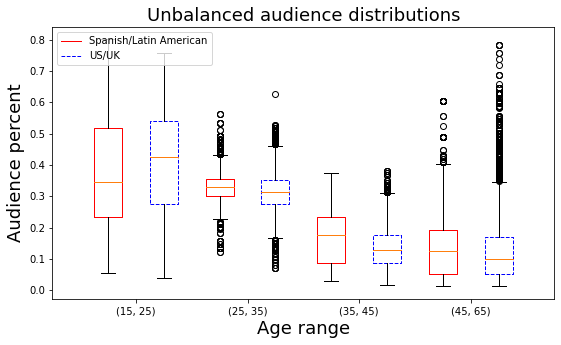

In [16]:
# check age in unbalanced data
# plot distribution per genre
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
age_category_vars = list(filter(lambda x: 'pct' in x, media_audience_data.columns))
latin_american_musician_media_audience_data = media_audience_data[media_audience_data.loc[:, 'media_genre']=='Spanish/Latin American']
us_american_musician_media_audience_data = media_audience_data[media_audience_data.loc[:, 'media_genre']=='US/UK']
latin_american_media_age_category_pcts = latin_american_musician_media_audience_data.loc[:, age_category_vars].transpose()
us_american_media_age_category_pcts = us_american_musician_media_audience_data.loc[:, age_category_vars].transpose()
# plot separately
X = np.arange(len(age_category_vars))
box_width = 0.25
box_offset = 0.25
plt.figure(figsize=(9,5))
box1 = plt.boxplot(latin_american_media_age_category_pcts, positions=X-box_offset, widths=box_width, boxprops={'color':'r', 'linestyle':'-'})
box2 = plt.boxplot(us_american_media_age_category_pcts, positions=X+box_offset, widths=box_width, boxprops={'color':'b', 'linestyle':'--'})
box_plots = [box1, box2]
box_plots = list(map(lambda x: x['boxes'][0], box_plots))
# TODO: rename genres
genre_vals = ['Spanish/Latin American', 'US/UK']
plt.xticks(X, audience_age_categories)
plt.xlabel('Age range', fontsize=18)
plt.ylabel('Audience percent', fontsize=18)
plt.legend(box_plots, genre_vals, loc='upper left')
plt.title('Unbalanced audience distributions', fontsize=18)
plt.show()

As expected the US American music skews slightly younger.

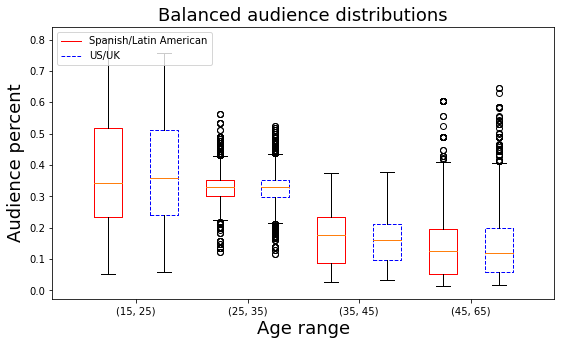

In [24]:
# check balance
# plot separately
matched_latin_american_media_age_category_pcts = matched_media_audience_data[matched_media_audience_data.loc[:, 'media_genre']=='Spanish/Latin American'].loc[:, age_category_vars].transpose()
matched_us_american_media_age_category_pcts = matched_media_audience_data[matched_media_audience_data.loc[:, 'media_genre']=='US/UK'].loc[:, age_category_vars].transpose()
box_width = 0.25
box_offset = 0.25
plt.figure(figsize=(9,5))
box1 = plt.boxplot(matched_latin_american_media_age_category_pcts, positions=X-box_offset, widths=box_width, boxprops={'color':'r', 'linestyle':'-'})
box2 = plt.boxplot(matched_us_american_media_age_category_pcts, positions=X+box_offset, widths=box_width, boxprops={'color':'b', 'linestyle':'--'})
box_plots = [box1, box2]
box_plots = list(map(lambda x: x['boxes'][0], box_plots))
genre_vals = ['Spanish/Latin American', 'US/UK']
plt.xticks(X, audience_age_categories)
plt.xlabel('Age range', fontsize=18)
plt.ylabel('Audience percent', fontsize=18)
plt.title('Balanced audience distributions', fontsize=18)
plt.legend(box_plots, genre_vals, loc='upper left')
plt.show()

Looking good so far!!

### Test genre distribution across loanword author groups

Now! Let's see the distribution of genres across author groups.

In [16]:
# separate authors by type
loanword_author_post_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t')
print(loanword_author_post_data.shape[0])
display(loanword_author_post_data.head())
# # get verb type counts
author_var = 'screen_name'
verb_type_var = 'loanword_type'
author_light_verb_pct = loanword_author_post_data.groupby(author_var).apply(lambda x: x[x.loc[:, 'loanword_type']=='light_verb_loanword'].shape[0] / x.shape[0])
print(author_light_verb_pct.head())
# identify "light verb" authors as those with at least 50% use
verb_use_cutoff = 0.5
light_verb_loanword_authors = author_light_verb_pct[author_light_verb_pct > verb_use_cutoff].index.tolist()
integrated_verb_loanword_authors = author_light_verb_pct[author_light_verb_pct < verb_use_cutoff].index.tolist()
print('%d light verb authors'%(len(light_verb_loanword_authors)))
print('%d integrated verb authors'%(len(integrated_verb_loanword_authors)))

87610


,loanword,loanword_verb,loanword_type,screen_name,user_id,text,date,id,user_description,user_location,...,us_american_artist_video_count,latin_american_artist_video_pct,total_music_count,latin_american_music_genre_pct,latin_american_music_genre_count,us_american_music_genre_count,latin_american_media_count,us_american_media_count,latin_american_media_pct,integrated_verb_pct
0,audit,auditamos,integrated_loanword,garrachavista,779318307585396736,@Sheiladarsy @anticuarta4 Y dime tu cuales 7.6...,NaN,892506833197424640,100% a la izquierda,Venezuela,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,ban,baneamos,integrated_loanword,emmanuelkiller5,4273648032,@adameamiro Eres tan hipocrita que antes nos h...,NaN,882375684823203841,"Felicidad?Que es eso, lo que todos siempre me ...","Chihuahua, Chihuahua",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ban,baneamos,integrated_loanword,danitolocirio13,482233447,@LVPibai Ibai te hace una normal de reclu? Así...,NaN,893999585953185793,#21. Me gusta Love Live. Reborn. Baraggan y Es...,"Valladolid, España",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,flip,flipas,integrated_loanword,danitolocirio13,482233447,Me echaba unas rankeds ahora que flipas,NaN,949837604362612736,#22. Vago...,"Valladolid, España",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,ban,banear,integrated_loanword,vcf973,883037197754093569,@MiiKeLMsT MIKEEL! CASI ME BANEAN POR COMPRAR ...,NaN,899277329012334593,.,Tenerife,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


screen_name
0001101011001e     0.0
0001sunshine       0.0
000822e5bc974e0    0.0
0009_bts           1.0
000i00i            0.0
dtype: float64
24892 light verb authors
55312 integrated verb authors


In [17]:
# get author media sharing data
video_share_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_youtube_video_data_full.tsv', sep='\t', usecols=['youtube_id', 'screen_name'])
music_share_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_author_spotify_link_data.tsv', sep='\t', usecols=['track_id', 'screen_name'])
video_share_data.rename(columns={'youtube_id' : 'media_id'}, inplace=True)
music_share_data.rename(columns={'track_id' : 'media_id'}, inplace=True)
video_share_data = video_share_data.assign(**{'media_type' : 'youtube'})
music_share_data = music_share_data.assign(**{'media_type' : 'spotify'})
media_share_data = pd.concat([video_share_data, music_share_data], axis=0)
# add genre data
print(media_share_data.loc[:, 'media_type'].value_counts())
display(media_share_data.head())

youtube    104455
spotify     21756
Name: media_type, dtype: int64


,media_id,screen_name,media_type
0,9FYlJp3uWt4,01800bateria,youtube
1,9VDmIwZkDBQ,01800bateria,youtube
2,7GFHgxjELqY,01800bateria,youtube
3,u5CVsCnxyXg,07jun11,youtube
4,2B6qerZlczw,07jun11,youtube


In [20]:
# restrict to matched data
matched_media_ids = set(matched_media_audience_data.loc[:, 'media_id'].unique())
valid_media_share_data = media_share_data[media_share_data.loc[:, 'media_id'].isin(matched_media_ids)]
# add genre type
media_id_genre_lookup = dict(zip(matched_media_audience_data.loc[:, 'media_id'].values, matched_media_audience_data.loc[:, 'media_genre']))
valid_media_share_data = valid_media_share_data.assign(**{
    'media_genre' : valid_media_share_data.loc[:, 'media_id'].apply(media_id_genre_lookup.get)
})
# TODO: why does merge generate more data than we have?
# valid_media_share_data = pd.merge(valid_media_share_data, matched_audience_media_data.loc[:, ['media_id', 'media_genre']], on='media_id', how='left')
# valid_media_share_data.drop_duplicates(['media_id', 'screen_name'], inplace=True)
print('%d/%d valid shares'%(valid_media_share_data.shape[0], media_share_data.shape[0]))
print(valid_media_share_data.loc[:, 'media_genre'].value_counts())
display(valid_media_share_data.head())

6501/126211 valid shares
us_american_music       3511
latin_american_music    2990
Name: media_genre, dtype: int64


,media_id,screen_name,media_type,media_genre
99,kbKztveYRgk,4everyoutini,youtube,latin_american_music
118,LjxulQ1bEWg,5_krisbless,youtube,us_american_music
131,UZkVqLjGM_I,5_krisbless,youtube,us_american_music
842,EVDGBEMpq5c,aurelioadasmepr,youtube,latin_american_music
845,EVDGBEMpq5c,aurelioadasmepr,youtube,latin_american_music


In [21]:
from scipy.stats import chi2_contingency
# get contingency matrix for chi-2 test
# count = media links shared (Latin American vs. US American)
light_verb_author_valid_media_share_data = valid_media_share_data[valid_media_share_data.loc[:, author_var].isin(light_verb_loanword_authors)]
integrated_verb_author_valid_media_share_data = valid_media_share_data[valid_media_share_data.loc[:, author_var].isin(integrated_verb_loanword_authors)]
contingency_matrix = [
    [light_verb_author_valid_media_share_data[light_verb_author_valid_media_share_data.loc[:, 'media_genre']=='us_american_music'].shape[0], 
     integrated_verb_author_valid_media_share_data[integrated_verb_author_valid_media_share_data.loc[:, 'media_genre']=='us_american_music'].shape[0]],
    [light_verb_author_valid_media_share_data[light_verb_author_valid_media_share_data.loc[:, 'media_genre']=='latin_american_music'].shape[0], 
     integrated_verb_author_valid_media_share_data[integrated_verb_author_valid_media_share_data.loc[:, 'media_genre']=='latin_american_music'].shape[0]]
]
contingency_matrix = pd.DataFrame(contingency_matrix, 
                                  index=['us_american_artist_share_count', 'latin_american_artist_share_count'], 
                                  columns=['light_verb_author', 'integrated_verb_author']).transpose()
contingency_matrix_norm = contingency_matrix.div(contingency_matrix.sum(axis=0), axis=1)
display(contingency_matrix)
display(contingency_matrix_norm)
test_stat, p_val, dof, expected = chi2_contingency(contingency_matrix.values)
print('difference is significant with test stat=%.3f (p=%.3E)'%(test_stat, p_val))

,us_american_artist_share_count,latin_american_artist_share_count
light_verb_author,1241,962
integrated_verb_author,2098,1817


,us_american_artist_share_count,latin_american_artist_share_count
light_verb_author,0.371668,0.346168
integrated_verb_author,0.628332,0.653832


difference is significant with test stat=4.170 (p=4.114E-02)


OK! We see again that the light verb authors tend to share slightly more US American music than the integrated verb authors.

### Test genre distribution across loanword author groups: frequent authors

Does this hold when we restrict to authors who post loanwords frequently?

In [22]:
min_count = 2
author_var = 'screen_name'
loanword_author_counts = loanword_author_post_data.loc[:, author_var].value_counts()
freq_loanword_authors = loanword_author_counts[loanword_author_counts >= min_count].index.tolist()
print('%d/%d freq loanword authors'%(len(freq_loanword_authors), len(loanword_author_counts)))
# get same light verb/integrated verb authors
freq_author_light_verb_pct = author_light_verb_pct[author_light_verb_pct.index.isin(freq_loanword_authors)]
freq_light_verb_loanword_authors = freq_author_light_verb_pct[freq_author_light_verb_pct > verb_use_cutoff].index.tolist()
freq_integrated_verb_loanword_authors = freq_author_light_verb_pct[freq_author_light_verb_pct < verb_use_cutoff].index.tolist()
print('%d light verb authors'%(len(freq_light_verb_loanword_authors)))
print('%d integrated verb authors'%(len(freq_integrated_verb_loanword_authors)))

4543/80921 freq loanword authors
1016 light verb authors
2810 integrated verb authors


In [23]:
from scipy.stats import chi2_contingency
# get contingency matrix for chi-2 test
# count = media links shared (Latin American vs. US American)
light_verb_author_valid_media_share_data = valid_media_share_data[valid_media_share_data.loc[:, author_var].isin(freq_light_verb_loanword_authors)]
integrated_verb_author_valid_media_share_data = valid_media_share_data[valid_media_share_data.loc[:, author_var].isin(freq_integrated_verb_loanword_authors)]
contingency_matrix = [
    [light_verb_author_valid_media_share_data[light_verb_author_valid_media_share_data.loc[:, 'media_genre']=='us_american_music'].shape[0], 
     integrated_verb_author_valid_media_share_data[integrated_verb_author_valid_media_share_data.loc[:, 'media_genre']=='us_american_music'].shape[0]],
    [light_verb_author_valid_media_share_data[light_verb_author_valid_media_share_data.loc[:, 'media_genre']=='latin_american_music'].shape[0], 
     integrated_verb_author_valid_media_share_data[integrated_verb_author_valid_media_share_data.loc[:, 'media_genre']=='latin_american_music'].shape[0]]
]
contingency_matrix = pd.DataFrame(contingency_matrix, 
                                  index=['us_american_artist_share_count', 'latin_american_artist_share_count'], 
                                  columns=['light_verb_author', 'integrated_verb_author']).transpose()
contingency_matrix_norm = contingency_matrix.div(contingency_matrix.sum(axis=0), axis=1)
display(contingency_matrix)
display(contingency_matrix_norm)
test_stat, p_val, dof, expected = chi2_contingency(contingency_matrix.values)
print('difference is significant with test stat=%.3f (p=%.3E)'%(test_stat, p_val))

,us_american_artist_share_count,latin_american_artist_share_count
light_verb_author,44,28
integrated_verb_author,167,227


,us_american_artist_share_count,latin_american_artist_share_count
light_verb_author,0.208531,0.109804
integrated_verb_author,0.791469,0.890196


difference is significant with test stat=7.876 (p=5.010E-03)


OK! This is another strong sign that light verb authors tend to share more US American music.